<h1 align=center><font size = 5>Applied Data Science Capstone</font></h1>
<h1 align=center><font size = 4>Faraz Khan</font></h1>
<h1 align=center><font size = 3>Finding potential spots to open Tim Hortons </font></h1>

## Table of contents
* [Introduction](#introduction)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction<a name="introduction"></a>

Tim Hortons Inc. is a fast food restaurant chain, specializing in coffee, doughnuts, and other fast food items. It is Canada's largest quick service restaurant chain; as of December 31, 2018, it had a total of 4,846 restaurants in 14 countries. The company has its headquarters in Toronto. Since it is an established brand, Many entrepreneurs seek to open their own their own chain.

The required capital to open your own store ranges from __$60,000__ to __600,000__ so it is of investor's best interest to find the best location to generate highest profits. In this project, I will use a trade area analysis named __thiessen polygons__ to determine potential new spots within the areas of Etobicoke, York, West Toronto and Central Toronto. This will help any investor looking to open Tim Hortons in these boroughs.

__Data:__

We will use the following wikipedia page to gather PostalCodes, Boroughs and Neighborhoods: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

This will give us all required boroughs in Toronto and their neighborhoods.

We will also need geographical coordinates for every neighborhood. The following link will be used:              
http://cocl.us/Geospatial_data

Coordinates wil be used to collect nearby venues given radius using __Foursquare API__.

__Importing required pacakges__:

In [105]:
# Importing required packages.
import pandas as pd
import scipy
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from scipy.spatial.distance import pdist, squareform
import numpy as np
#import pgeocode
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
import requests # library to handle requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install haversine
import haversine as hs

## Methodology<a name="methodology"></a>

We need coordinates of Tim Hortons locations within chosen boroughs. Once we make the dataframe and apply thiessen polygon technique, we will have polygons which tells us area of influence each Tim Hortons has. The vertices of polygons are spots where a new Tim Hortons could be opened. We will apply some constraints to choose best spots.

### Making the DataFrame.

In [2]:
# Using the website link given and making a DataFrame our of it.
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)
Neighbourhood = pd.DataFrame(dfs[0])
Neighbourhood['Postal Code'] = Neighbourhood['Post Code']
Neighbourhood.drop('Post Code', axis=1,inplace=True)
#Displaying DataFrame
Neighbourhood.head(10)

,Borough,Neighborhood,Postal Code
0,Not assigned,Not assigned,M1A
1,Not assigned,Not assigned,M2A
2,North York,Parkwoods,M3A
3,North York,Victoria Village,M4A
4,Downtown Toronto,"Regent Park, Harbourfront",M5A
5,North York,"Lawrence Manor, Lawrence Heights",M6A
6,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A
7,Not assigned,Not assigned,M8A
8,Etobicoke,"Islington Avenue, Humber Valley Village",M9A
9,Scarborough,"Malvern, Rouge",M1B



Let's change the string 'Not assigned' to NaN so it can be removed from DataFrame

In [3]:
#Chaning 'Not assigned' to NaN.
Neighbourhood.replace('Not assigned', np.NaN, inplace=True)

#Dropping NaN values.
Neighbourhood.dropna(inplace=True)

#Displaying All Neighborhood names.
Neighbourhood['Borough'].unique()

array(['North York', 'Downtown Toronto', 'Etobicoke', 'Scarborough',
       'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

Let's see how many rows and columns we have in the end.

In [4]:
Neighbourhood.shape

(103, 3)

Let's add Latitude and Longitude of neighbourhoods to our DataFrame.

In [5]:
Neighbourhood_coordinates = pd.read_csv("http://cocl.us/Geospatial_data")
#Merging two DataFrames.
merged_neighbour = pd.merge(Neighbourhood_coordinates, Neighbourhood, on='Postal Code')
merged_neighbour = merged_neighbour[['Postal Code','Borough', 'Neighborhood', 'Latitude','Longitude']]

#Selecting chosen boroughs
chosen_b_df = merged_neighbour[(merged_neighbour['Borough'] == 'West Toronto')|(merged_neighbour['Borough']=='York')|\
                                (merged_neighbour['Borough']=='Etobicoke')|(merged_neighbour['Borough']=='Central Toronto')].reset_index(drop=True)
chosen_b_df.head(15)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M4P,Central Toronto,Davisville North,43.712751,-79.390197
2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,M4S,Central Toronto,Davisville,43.704324,-79.388790
4,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
5,M4V,Central Toronto,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049
6,M5N,Central Toronto,Roselawn,43.711695,-79.416936
7,M5P,Central Toronto,"Forest Hill North & West, Forest Hill Road Park",43.696948,-79.411307
8,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678
9,M6C,York,Humewood-Cedarvale,43.693781,-79.428191


Get Toronto coordinates

In [6]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Etobicoke are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Etobicoke are 43.6534817, -79.3839347.


Creating the map displaying neighborhoods from chosen boroughs.

In [7]:
# create map of Downtown Toronto using latitude and longitude values
map_chosen_b = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(chosen_b_df['Latitude'], chosen_b_df['Longitude'],chosen_b_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chosen_b)  
    
map_chosen_b

#### Explore Neighborhoods in chosen boroughs

I use the Foursquare API to explore the neighborhoods and segment them.

In [8]:
CLIENT_ID = 'EHJAOYBBN3OFIBFP2D3MSC3W0XEP0PQ410OIFUISK0P42JZY' 
CLIENT_SECRET = 'JSQOOEGOFCG435OITCYKUM5ICMQVZA3PPOKRZAUUCSYA4XXU' 
VERSION = '20180605' 

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius_1 = 1300 # define radius

Function for getting venues

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius_1, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


Create the dataframe for chosen boroughs using function.

In [10]:
chosen_b_venues = getNearbyVenues(names=chosen_b_df['Neighborhood'],
                                  latitudes=chosen_b_df['Latitude'],
                                  longitudes=chosen_b_df['Longitude']
                                  )

Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
Humewood-Cedarvale
Caledonia-Fairbanks
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
Del Ray, Mount Dennis, Keelsdale and Silverthorn
Runnymede, The Junction North
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swansea
New Toronto, Mimico South, Humber Bay Shores
Alderwood, Long Branch
The Kingsway, Montgomery Road, Old Mill North
Old Mill South, King's Mill Park, Sunnylea, Humber Bay, Mimico NE, The Queensway East, Royal York South East, Kingsway Park South East
Mimico NW, The Queensway West, South of Bloor, Kingsway Park South West, Royal York South West
Islington Avenue, Humber Valley Village
West Deane Park, Princess Gardens, Martin Grove, Islington, Clov

In [11]:
chosen_b_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alderwood, Long Branch",50,50,50,50,50,50
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
Caledonia-Fairbanks,38,38,38,38,38,38
Davisville,98,98,98,98,98,98
Davisville North,60,60,60,60,60,60
"Del Ray, Mount Dennis, Keelsdale and Silverthorn",43,43,43,43,43,43
"Dufferin, Dovercourt Village",100,100,100,100,100,100
"Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood",31,31,31,31,31,31
"Forest Hill North & West, Forest Hill Road Park",90,90,90,90,90,90


Find out how many unique categories can be curated from all the returned venues

In [12]:
len(chosen_b_venues['Venue Category'].value_counts())

236

#### Tim Hortons

Now that we have all venues in 1300 meters radius around neighborhoods, Let's collect all Tim Hortons in a single DataFrame.

In [13]:
tim_hortons_df=chosen_b_venues[chosen_b_venues['Venue'] == 'Tim Hortons']
tim_hortons_df.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
27,Lawrence Park,43.728020,-79.388790,Tim Hortons,43.727324,-79.379563,Coffee Shop
34,Lawrence Park,43.728020,-79.388790,Tim Hortons,43.728811,-79.403473,Coffee Shop
102,Davisville North,43.712751,-79.390197,Tim Hortons,43.710746,-79.377373,Coffee Shop
174,"North Toronto West, Lawrence Park",43.715383,-79.405678,Tim Hortons,43.709507,-79.398662,Coffee Shop
189,"North Toronto West, Lawrence Park",43.715383,-79.405678,Tim Hortons,43.707264,-79.399511,Coffee Shop
199,"North Toronto West, Lawrence Park",43.715383,-79.405678,Tim Hortons,43.706385,-79.397995,Coffee Shop
200,"North Toronto West, Lawrence Park",43.715383,-79.405678,Tim Hortons,43.704273,-79.409193,Coffee Shop
284,Davisville,43.704324,-79.388790,Tim Hortons,43.710746,-79.377373,Coffee Shop
360,"Moore Park, Summerhill East",43.689574,-79.383160,Tim Hortons,43.698841,-79.386396,Coffee Shop
447,"Summerhill West, Rathnelly, South Hill, Forest...",43.686412,-79.400049,Tim Hortons,43.675800,-79.403532,Coffee Shop


Let's display them on the map.

In [15]:
# create map of Downtown Toronto using latitude and longitude values
map_chosen_b = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(tim_hortons_df['Venue Latitude'],tim_hortons_df['Venue Longitude'],tim_hortons_df['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=10,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chosen_b)  
    
map_chosen_b

## Analysis<a name="analysis"></a>

### Thiessen Polygon

Thiessen polygons are generated from a set of sample points such that each polygon defines an area of influence around its sample point, so that any location inside the polygon is closer to that point than any of the other sample points.In our case, It will determine customer influence for each location.

Let's map our locations onto a 2D plane.

Text(0.5, 1.0, 'Location of Tim Hortons on a 2D plane')

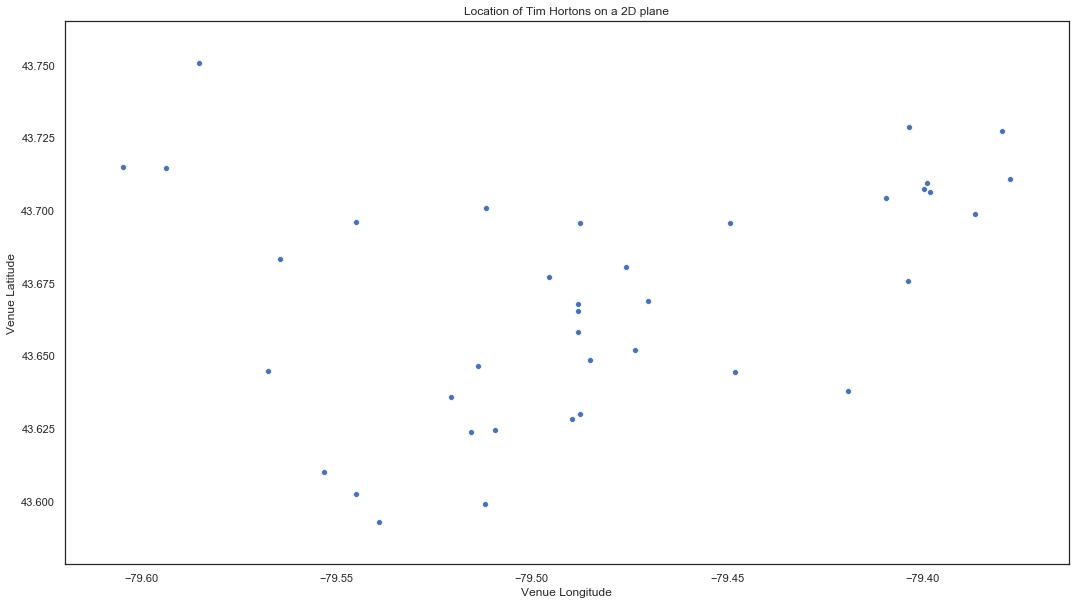

In [142]:
plt.figure(figsize=(18, 10))
ax = sns.scatterplot(x='Venue Longitude', y='Venue Latitude', data=tim_hortons_df)
plt.title('Location of Tim Hortons on a 2D plane')

Let's apply Thiessen polygon technique to see customer segmentation.

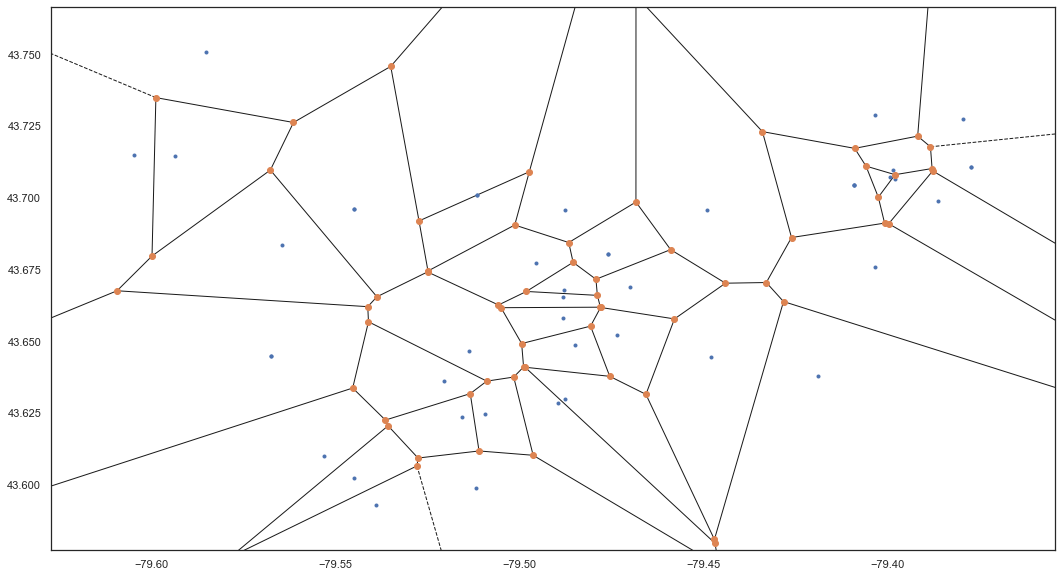

In [102]:
tim_hortons_lst=list(zip(tim_hortons_df['Venue Longitude'],tim_hortons_df['Venue Latitude']))
vor = Voronoi(tim_hortons_lst)

# plot
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
voronoi_plot_2d(vor, ax=ax)
plt.show()

As it can be seen, black lines are bisectors that shows area of influence for each location and the yellow points at which the bisectors intersect determine the locations of the Thiessen polygon vertices. These vertices are potential where a new Tim Hortons can be opened. 

Let's make a DataFrame out of Thiessen polygon vertices.

In [18]:
potential_vertices=vor.vertices

potential_df = pd.DataFrame()
Latitude = []
Longitude = []
for item in potential_vertices:
    Latitude.append(item[1])
    Longitude.append(item[0])
potential_df['Latitude'] = Latitude
potential_df['Longitude'] = Longitude
potential_df.head()

,Latitude,Longitude
0,45.511085,-79.280659
1,43.667546,-79.609365
2,43.679645,-79.599870
3,43.734864,-79.598819
4,43.770392,-79.468434


Let's display these spots on the map along with curent Tim Hortons. We will make a radius of __500__ meters around each vertices.

In [143]:
map_chosen_b = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng in zip(potential_df['Latitude'],potential_df['Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        color='red',
        fill=False,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chosen_b)
    
for lat, lng, label in zip(tim_hortons_df['Venue Latitude'],tim_hortons_df['Venue Longitude'],tim_hortons_df['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=10,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chosen_b)
    
map_chosen_b

Here we see all our potential new locations through thiessen polygons. We can narrow down our spots if we eliminate impossible and least desirable potential locations. We will display output below after applying these four constraints in to limit output:

<ul>
    <li>Potential area must be atleast 15 kilometers away from current Tim Hortons.</li>
    <li>Potential area must be atleast 3 kilometers away from other potential areas.</li>
    <li>Potential area must be on land.</li>
    <li>Potential area must be within chosen boroughs i.e; Etobicoke, York, West and Central Toronto.</li>
</ul>


In [358]:
potential_df_1 = potential_df.copy()

#Removing potential locations within 15 km radius of other Tim Hortons.
potential_lst = list(zip(potential_df_1['Latitude'],potential_df_1['Longitude']))
tim_lst = list(zip(tim_hortons_df['Venue Latitude'],tim_hortons_df['Venue Longitude']))

potential_2 = []
for pl in potential_lst:
    for tl in tim_lst: 
        loc1=pl
        loc2=tl
        distance = hs.haversine(loc1,loc2)
        if distance >= 15:
            if pl not in potential_2:
                potential_2.append(pl)
        else:
            if loc2 in potential_2:
                potential_2.remove(loc2)
            
#Removing potential locations within 3km radius of each other.    
potential_3 = []
for pl in potential_2:
    for ix in range(len(potential_2)-1):
        loc1=pl
        loc2=potential_2[ix+1]
        distance = hs.haversine(loc1,loc2)
        if distance >= 3:
            if pl not in potential_3:
                potential_3.append(pl)
        else:
            if loc2 in potential_3:
                potential_3.remove(loc2)
                
#Making a DataFrame.
potential_df_3 = pd.DataFrame({'Latitude':[],'Longitude':[]})
for i in range(len(potential_3)):
    potential_df_3.loc[i] = [potential_3[i][0],potential_3[i][1]]
    
#Removing points on water and not within chosen boroughs.
potential_df_3 = potential_df_3[((potential_df_3['Longitude']<potential_df_3['Longitude'].max())\
                      & (potential_df_3['Longitude']>potential_df_3['Longitude'].min())\
                      & (potential_df_3['Latitude']<potential_df_3['Latitude'].max())\
                      & (potential_df_3['Latitude']>potential_df_3['Latitude'].min()))\
                      & ((potential_df_3['Latitude']>43.602414) | (potential_df_3['Longitude']<-79.539087))]
potential_df_3 = potential_df_3[(potential_df_3['Longitude']<potential_df_3['Longitude'].max())\
                      &(potential_df_3['Latitude']<potential_df_3['Latitude'].max())]
potential_df_3=potential_df_3[potential_df_3['Longitude']>-79.578537]

map_chosen_b = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng in zip(potential_df_3['Latitude'],potential_df_3['Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        color='red',
        fill=False,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chosen_b)
    
for lat, lng, label in zip(tim_hortons_df['Venue Latitude'],tim_hortons_df['Venue Longitude'],tim_hortons_df['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=10,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_chosen_b)
    
map_chosen_b

## Results, Discussion

### Results

As it can be seen, our technique has selected 5 spots where a new potential Tim Hortons can be opened and these locations fulfill all our constraints. Earlier we had decided to make a radius of 500 meters around our spots. This was to allow the possibility of venue located on vertices to not be available. Further selection of a venue will depend on availibility and prices of venues within the spot.

### Discussion

There are some issues we should discuss. Thiessen polygons is a technique that uses Euclidean distance create polygons. The __Euclidean distance__ or __Euclidean metric__ is the "ordinary" straight-line distance between two points in Euclidean space. In our case, Euclidean space is 2 dimensional so forumla is:

$$
Distance = \sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}
$$

What we have in our dataset are __geographical coordinates__, which is a three-dimensional reference system that locates points on the Earth's surface. It should be noted that Euclidean distance calculated through geographical coordinates should not be accurate due to the concept of curvature in a 2 dimensional surface. However, Since our area of analysis is relatively small, this inaccuracy is negligble.

It should also be noted that this model makes an assumption about the area of influence shared between 2 Tim Hortons. Since area between two Tim Hortons is always bisected, Its assumed both have equal influence between them. That may not always be the case, as influence a single shop has may change with time due to various factors such as bad ratings, timings of the store etc.

## Conclusion<a name="conclusion"></a>

Purpose of this project was to find potential new spots for an investor looking to open his own Tim Hortons chain. First we collected location of all Tim Hortons within the area of Etobicoke, York, West and Central Toronto using Foursquare API. 

Then we applied Thiessen polygon technique and collected thiessen polygon vertices. To eliminate vertices that could not be desirable new spots, we applied 4 constraints and in the end, got top 5 potential spots an investor could look at.